In [1]:
import sys
sys.path.append('..')
from fastbook import *
from load_data import *
from models import *

In [2]:
from PIL import Image



In [72]:
fns = get_originals(path)
fns[0]

Path('../preprocessed/NISDCC-012_012_004_6g.PNG')

In [66]:
is_valid_sigcomp2009_train(fns[0])

False

In [58]:
Counter(get_y_sigcomp2009_train(f) for f in fns)

Counter({'012': 5,
         '008': 5,
         '002': 5,
         '011': 5,
         '005': 5,
         '004': 5,
         '007': 5,
         '006': 5,
         '010': 5,
         '009': 5,
         '001': 5,
         '003': 5})

In [4]:
path = Path('../preprocessed')
path_test = Path('../preprocessed-test')

In [5]:


train_ds, valid_ds = calc_dss(path, get_originals, get_x_sigcomp2009, get_y_sigcomp2009_train,
                              is_valid_sigcomp2009_train)
len(train_ds), len(valid_ds)

60 files loaded.
50 training samples / 10 validation samples
mean: 0.04446401447057724 std: 0.1654745489358902 (on train)


(100, 20)

In [9]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=32).cuda()

In [38]:
fns = get_image_files(path)
fns = [ fn for fn in fns if is_original_sigcomp2009_train(fn) ]
len(fns)

60

tensor(1., device='cuda:0')


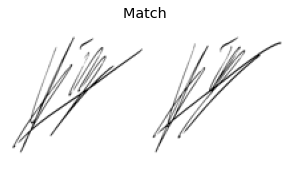

In [12]:
b = dls.one_batch()
idx=random.randint(0,32)
print(b[2][idx])
show_siamese(b[0][idx], b[1][idx], b[2][idx], cmap='binary', figsize=(5,5))

1

<AxesSubplot:>

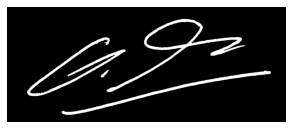

In [12]:
fn = fns[3]

img = PILImageBW.create(fn)

img = ToTensor()(img)/255.0
show_image(img, cmap='gray')

In [13]:
img

TensorImageBW([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [284]:
def twospirals(n_points, noise=.5):
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))
X, y = twospirals(1000)
X = np.concatenate((X, 35*np.random.rand(X.shape[0],1)),axis=1)

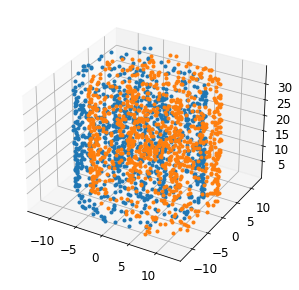

In [285]:
plt.figure(figsize=(8,5))
ax = plt.axes(projection='3d')
ax.plot3D(X[y==0,0], X[y==0,1], X[y==0,2], '.', label='class 1')
ax.plot3D(X[y==1,0], X[y==1,1], X[y==1,2], '.', label='class 1')


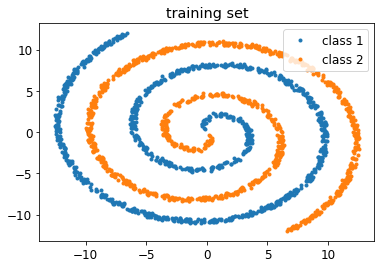

In [286]:
plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.legend()
plt.show()

In [287]:
X_pca = tensor(X).pca(2)
a,b = X_pca.t()

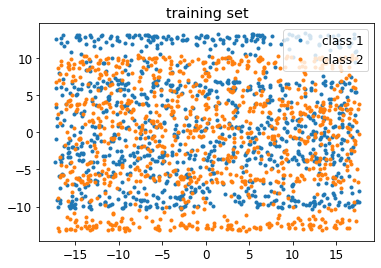

In [288]:
plt.title('training set')
plt.plot(a[y==0], b[y==0], '.', label='class 1')
plt.plot(a[y==1], b[y==1], '.', label='class 2')
plt.legend()
plt.show()

In [253]:
e = nn.Sequential(
    nn.Linear(X.shape[1],max(3,X.shape[1]//2)),
    nn.ReLU(),
    nn.Linear(max(3,X.shape[1]//2),2),
    )
d = nn.Sequential(
    nn.ReLU(),
    nn.Linear(2,max(3,X.shape[1]//2)),
    nn.ReLU(),
    nn.Linear(max(3,X.shape[1]//2),X.shape[1]),
    )
ae = nn.Sequential(e,d).cuda()
ae

Sequential(
  (0): Sequential(
    (0): Linear(in_features=3, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=2, bias=True)
  )
  (1): Sequential(
    (0): ReLU()
    (1): Linear(in_features=2, out_features=3, bias=True)
    (2): ReLU()
    (3): Linear(in_features=3, out_features=3, bias=True)
  )
)

In [64]:
t = tensor(X)
t.shape

torch.Size([2000, 3])

In [155]:
yt = tensor(y)
yt.shape

torch.Size([2000])

In [168]:
yt=yt.bool()
yt


tensor([False, False, False,  ...,  True,  True,  True])

In [198]:
with torch.no_grad():
    xr=e(t.cuda())

In [199]:
xr=xr.cpu()
xr

tensor([[  -25.3129,  2545.6921],
        [ -203.2336, 20754.9473],
        [  -24.7671,  2503.6228],
        ...,
        [  -22.8681,  2338.0427],
        [ -107.3619, 10988.1348],
        [ -155.7894, 15851.5566]])

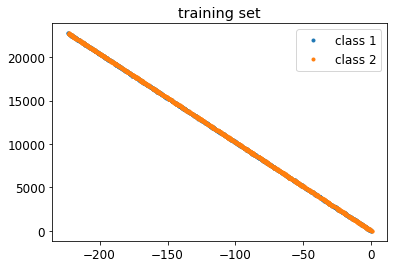

In [203]:
plt.title('training set')
plt.plot(xr[y==0,0], xr[y==0,1], '.', label='class 1')
plt.plot(xr[y==1,0], xr[y==1,1], '.', label='class 2')
plt.legend()
plt.show()

In [204]:
from torch.utils.data import TensorDataset
ds = TensorDataset(t)
dl = DataLoader(ds, bs=32, device=torch.device('cuda'))


In [191]:
import torch.optim as optim

def do_epochs(epochs,lr):
    loss = nn.MSELoss()
    opt = optim.Adam(ae.parameters(), lr=lr)
    for i in range(epochs):
        epoch_loss = 0.0
        for x in dl:
            x=x[0]
            opt.zero_grad()
            xp = ae(x.cuda())
            x_loss = loss(x, xp)
            x_loss.backward()
            opt.step()
            epoch_loss += x_loss.item()
        epoch_loss /= len(dl)
        if not(i%20):
            print(f'epoch : {i}/{epochs}, loss = {epoch_loss}')

In [205]:
# epoch : 980/1000, loss = 895860171.6825397
do_epochs(1000,0.01)

epoch : 0/1000, loss = 279505754.15873015
epoch : 20/1000, loss = 279505747.3015873
epoch : 40/1000, loss = 279505742.47619045
epoch : 60/1000, loss = 279505737.6507937
epoch : 80/1000, loss = 279505729.7777778


KeyboardInterrupt: 

In [212]:
import sklearn as sk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import SparsePCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import FastICA
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.random_projection import SparseRandomProjection


In [276]:
from sklearn.decomposition import KernelPCA
XTT =  KernelPCA(n_components=2, kernel='poly').fit_transform(X)
XTT.shape

(2000, 2)

In [282]:
mds = MDS(n_components=2, n_init=12, max_iter=1200, metric=True, n_jobs=4, random_state=2019)
XTT = mds.fit_transform(X)

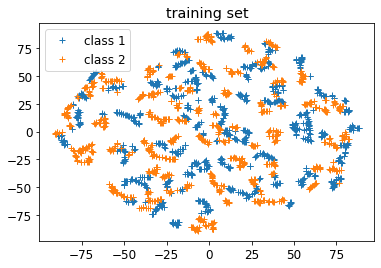

In [308]:
plt.title('training set')
plt.plot(XTT[y==0,0], XTT[y==0,1], '+', label='class 1')
plt.plot(XTT[y==1,0], XTT[y==1,1], '+', label='class 2')
plt.legend()
plt.show()

In [307]:
tsne = TSNE(n_components=2,learning_rate=300,perplexity = 9,early_exaggeration = 50,init = 'random',  random_state=2019)
XTT = tsne.fit_transform(X)

In [280]:

lle = LocallyLinearEmbedding(n_components=2, n_neighbors = 10,method = 'modified', n_jobs = 4,  random_state=2019)
lle.fit(X)
XTT = lle.transform(X)

In [291]:
isomap = Isomap(n_components=3, n_jobs = 4, n_neighbors = 5)
isomap.fit(X)
XTT = isomap.transform(X)

In [310]:
class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, fns, get_x, get_y, valid_flag, tsfm=None):
        self.fns = fns
        self.valid_flag = valid_flag
        self.get_x = get_x
        self.get_y = get_y
        self.tsfm = tsfm
        self.cls = [ get_y(f) for f in fns ]
        self.all_classes = set(self.cls)
        self.len = 2*len(fns)
        
        self.label_to_indexes = defaultdict(list)
        for i,l in enumerate(self.cls): self.label_to_indexes[l].append(i)

        if valid_flag: self.draw_memo = [ self._draw(i) for i in range(self.len) ]
        
    def __getitem__(self, i):
        idx1     = i//2
        is_match    = i%2
        idx2 = self.draw_memo[i] if self.valid_flag else self._draw(i)
        assert ((self.cls[idx1]==self.cls[idx2])==is_match)
        t1 = self.get_x( self.fns[idx1] )
        t2 = self.get_x( self.fns[idx2] )
        if self.tsfm is not None:
            t1=self.tsfm(t1)
            t2=self.tsfm(t2)
        return ( t1, t2, torch.Tensor([is_match]).squeeze() )
    
    def __len__(self): return self.len
    
    def _draw(self, i):
        idx     = i//2
        is_match    = i%2
        if is_match: new_cls = self.cls[idx]
        else: new_cls = random.choice([l for l in self.all_classes if l != self.cls[idx]])
        return random.choice(self.label_to_indexes[new_cls])